In [1]:
onedrive = r"C:\Users\mikek\OneDrive"
# %matplotlib ipympl
# %matplotlib qt
# %matplotlib widget
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *
import matplotlib as mpl

%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# IO

In [5]:
db = CaseDB()

toload = {
    # "base0" : "sta10a-bestshot",
    # "base1" : "sta10b-ar1pc",
    # "base2" : "sta10c-ar2pc",
    # "base4" : "sta10d-ar4pc",
    "vis0" : "sta11a-ion_viscosity",
    "vis1" : "sta11b-ar1pc",
    "vis2" : "sta11c-ar2pc",
    "vis4" : "sta11d-ar4pc",
    "vis8" : "sta11e-ar8pc",
    "optimised1" : "stc9a-defaultgrid_800pts_ar1pc",
    "optimised2" : "stc9b-ar2pc",
    "optimised4" : "stc9c-ar4pc",
    "optimised8" : "stc9d-ar8pc",
}

cs = dict()   # casestore

for name in toload:
    print(f"Loading {toload[name]}")
    cs[name] = Load.case_1D(db.casepaths[toload[name]])


Loading sta11a-ion_viscosity


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading sta11b-ar1pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading sta11c-ar2pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading sta11d-ar4pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading sta11e-ar8pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc9a-defaultgrid_800pts_ar1pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc9b-ar2pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc9c-ar4pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


Loading stc9d-ar8pc


c:\Users\mikek\anaconda3\envs\new\lib\site-packages\dask\array\core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


In [3]:
write_file(cs, "a7.pkl")

a7.pkl written


In [9]:
cs = read_file("a7.pkl")

a2.pkl loaded


In [5]:
%matplotlib widget

In [194]:
cs["vis0"].ds.isel(t=-1).isel(pos=slice(1,-1))["Ne"].isel(pos=0).values

array(6.46429855e+19)

# Plots

## Case summary table

In [52]:
# fig, ax = plt.subplots(dpi = 100, figsize = (8,6))

df = pd.DataFrame()
for i in [0,1,2,4]:
    ds = cs[f"base{i}"].ds
    df.loc[i, "nu"] = ds["Ne"].isel(pos=1, t = -1).values
    df.loc[i, "avg_ncalls"] = np.mean(ds["ncalls"].values)
    df.loc[i, "max_ncalls"] = np.max(ds["ncalls"].values)
    
df

,nu,avg_ncalls,max_ncalls
0,6.464513e+19,29832.043189,1234068.0
1,3.771914e+19,13838.126246,637671.0
2,2.898461e+19,42099.577114,1634371.0
4,2.185204e+19,125065.855721,1481567.0


## Numerics


### CVODE diagnostics

In [4]:

def plot(data):
    num_plots = len(data.keys())

    t = ds.coords["t"]

    fig = plt.figure(dpi=dpi)
    fig.set_figheight(4)
    fig.set_figwidth(num_plots*4)
    fig.subplots_adjust(bottom = 0.2)

    # Plot grid
    gs = mpl.gridspec.GridSpec(
                                    ncols=num_plots, nrows=1,
                                    wspace = wspace
                                    )



    axes = [None] * len(data.keys())


    for i, param in enumerate(data.keys()):
        # All plots after the first one share x and y axes
        if i == 0:
            axes[i] = fig.add_subplot(gs[i])
        else:
            axes[i] = fig.add_subplot(gs[i], sharex=axes[0])
            
        axes[i].plot(t, data[param])
        axes[i].set_title(param)
        axes[i].grid()
        
data = dict()
data["ncalls"] = ds["ncalls"].values
data["order"] = ds["cvode_last_order"].values
data["precon_frac"] = np.divide(ds["cvode_npevals"],(ds["cvode_nfevals"]))
# data["stab_lims"] = ds["cvode_stab_lims"]
plot(data)

data = dict()
data["last_timestep"] = ds["cvode_last_step"]
data["num_fails"] = np.clip(np.gradient(ds["cvode_num_fails"]), 0, None)
data["nonlin_fails"] = np.clip(np.gradient(ds["cvode_nonlin_fails"]), 0, None) #np.gradient(t, ds["cvode_nonlin_fails"])
plot(data)


NameError: name 'ds' is not defined

## Correlate slowdowns

In [22]:
# %matplotlib widget
%matplotlib inline

### Ncalls with increasing Ar

In [17]:
vis = ["vis1", "vis2", "vis4", "vis8"]
optimised = ["optimised1", "optimised2", "optimised4", "optimised8"]

In [ ]:
labels = ["Start, 1% Ar", "6% Ar", "8% Ar", "Add particles and settle", "2x power step"]

fig, ax = plt.subplots(figsize=(8,5), dpi = 120)

colors = ds.metadata["colors"]

data = list()
for i, name in enumerate(toload):
    ds = cs[name].ds.isel(pos = slice(2,-2))
    data.append(ds["wtime"].cumsum())

for i, name in enumerate(toload):
    ds = cs[name].ds.isel(pos = slice(2,-2))

        
    t = ds["t"]
    # t = ds["t"]-offset if name == "stop" else ds["t"]
    if i > 0:
        data[i] = data[i] + data[i-1][-1]
        
    ax.plot(t * 100, data[i] / 3600, label = labels[i], color = colors[i])
    # ds["Rar"].idxmax(dim="pos").plot(ax = ax, label = name)
    
fig.legend(loc="upper left", bbox_to_anchor=(0.95,0.95))
ax.set_xlabel("Time [ms]")
# ax.set_ylim(None,7)
ax.grid(alpha=0.3)
ax.set_ylabel("Runtime [hrs]")
ax.set_title("Simulation time")

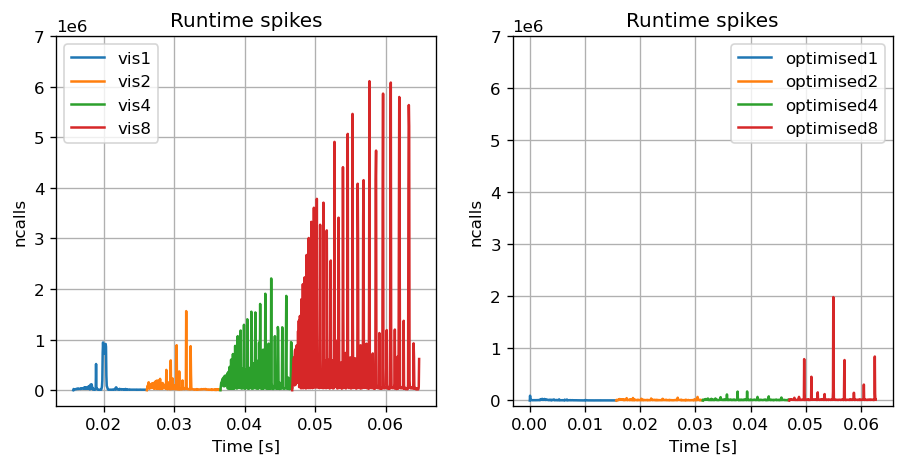

In [19]:
fig, axes = plt.subplots(1,2, figsize = (4.5*2, 4), dpi = 120)

data = list()
for i, name in enumerate(vis):
    ds = cs[name].ds.isel(pos = slice(2,-2))
    data.append(ds["wtime"].cumsum())
    
for i, name in enumerate(vis):
    
for name in vis:
    ds = cs[name].ds
    ds["ncalls"].plot(ax = axes[0], label = name)
    
for name in optimised:
    ds = cs[name].ds
    ds["ncalls"].plot(ax = axes[1], label = name)
    
for ax in axes:
    ax.grid()
    ax.set_title("Runtime spikes")
    ax.legend()
    ax.set_ylim(None,7e6)

### Position of peak momentum gradient

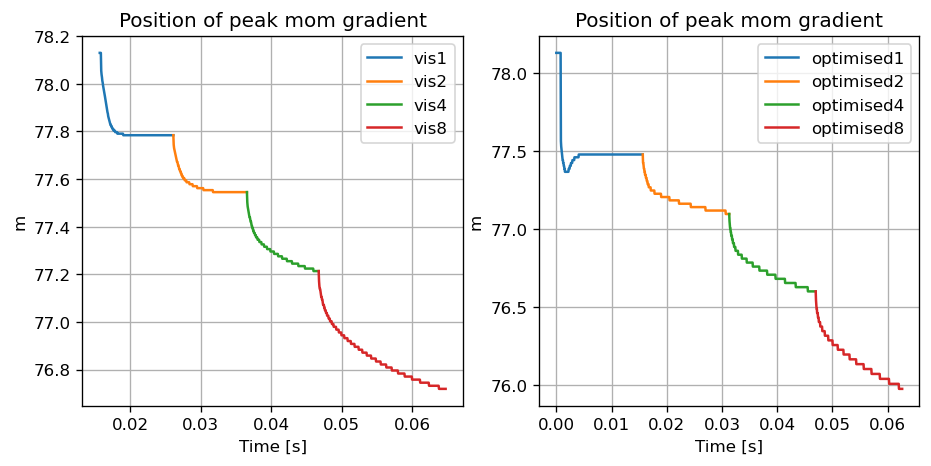

In [20]:
fig, axes = plt.subplots(1,2, figsize = (4.5*2, 4), dpi = 120)

for name in vis:
    ds = cs[name].ds
    ds["NVd+"].differentiate("pos").idxmax(dim="pos").plot(ax =axes[0], label = name)
    
for name in optimised:
    ds = cs[name].ds
    ds["NVd+"].differentiate("pos").idxmax(dim="pos").plot(ax =axes[1], label = name)

for ax in axes:
    ax.grid()
    ax.set_title("Position of peak mom gradient")
    ax.legend()
    ax.set_ylabel("m")

### Movement of peak gradient position

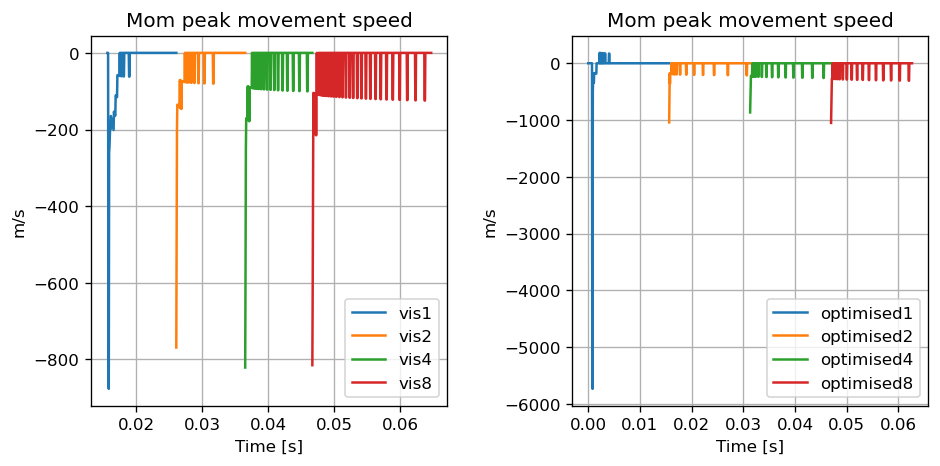

In [21]:
fig, axes = plt.subplots(1,2, figsize = (4.5*2, 4), dpi = 120)
fig.subplots_adjust(wspace=0.35)

for name in vis:
    ds = cs[name].ds
    ds["NVd+"].differentiate("pos").idxmax(dim="pos").differentiate("t").plot(ax =axes[0], label = name)
    
for name in optimised:
    ds = cs[name].ds
    ds["NVd+"].differentiate("pos").idxmax(dim="pos").differentiate("t").plot(ax =axes[1], label = name)

for ax in axes:
    ax.grid()
    ax.set_title("Mom peak movement speed")
    ax.legend()
    ax.set_ylabel("m/s")

### Grid at peak gradient point

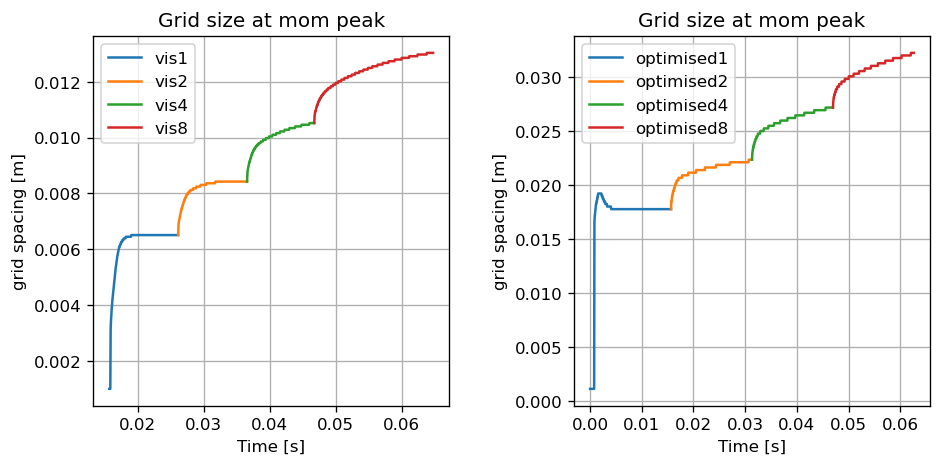

In [22]:
fig, axes = plt.subplots(1,2, figsize = (4.5*2, 4), dpi = 120)
fig.subplots_adjust(wspace=0.35)

for name in vis:
    ds = cs[name].ds
    maxpos = ds["NVd+"].differentiate("pos").idxmax(dim="pos")
    ds["dy"].sel(pos=maxpos).plot(ax =axes[0], label = name)
    
for name in optimised:
    ds = cs[name].ds
    maxpos = ds["NVd+"].differentiate("pos").idxmax(dim="pos")
    ds["dy"].sel(pos=maxpos).plot(ax =axes[1], label = name)

for ax in axes:
    ax.grid()
    ax.set_title("Grid size at mom peak")
    ax.legend()
    ax.set_ylabel("grid spacing [m]")

### Minimum neutral density

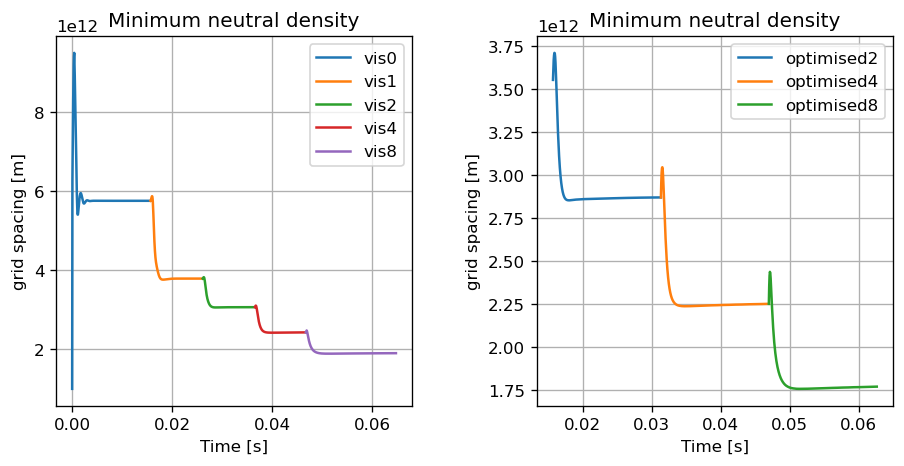

In [16]:
fig, axes = plt.subplots(1,2, figsize = (4.5*2, 4), dpi = 120)
fig.subplots_adjust(wspace=0.35)

for name in vis:
    ds = cs[name].ds.isel(pos=slice(1,-1))
    ds["Nd"].min(dim="pos").plot(ax =axes[0], label = name)
    
for name in optimised:
    ds = cs[name].ds.isel(pos=slice(1,-1))
    ds["Nd"].min(dim="pos").plot(ax =axes[1], label = name)

for ax in axes:
    ax.grid()
    ax.set_title("Minimum neutral density")
    ax.legend()
    ax.set_ylabel("grid spacing [m]")

## Front summary plot

NameError: name 'caselabels' is not defined

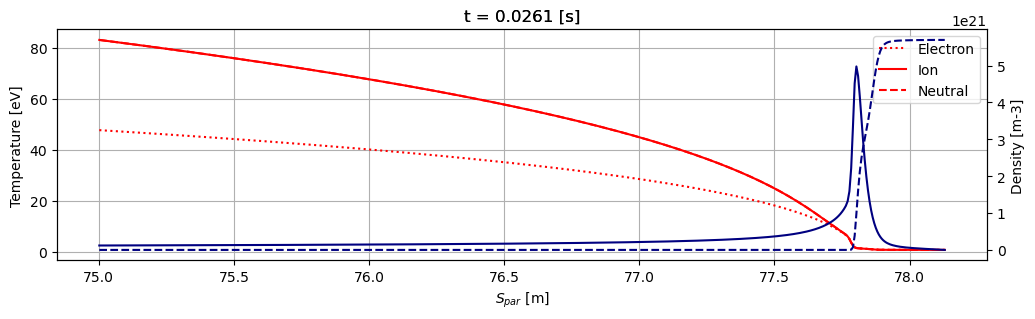

In [ ]:
casename = "vis1"
ds = cs[casename].ds.isel(pos=slice(1,-1), t = -1)
ds = ds.sel(pos=slice(75,None))

fig, ax = plt.subplots(dpi = 100, figsize = (12,3))
ds["Te"].plot(ax = ax, c = "r", ls = ":", label = "Electron")
ds["Td+"].plot(ax = ax, c = "r", ls = "-", label = "Ion")
ds["Td+"].plot(ax = ax, c = "r", ls = "--", label = "Neutral")

ax2 = ax.twinx()
ds["Ne"].plot(ax = ax2, c = "navy", ls = "-")
ds["Nd"].plot(ax = ax2, c = "navy", ls = "--")

# ax.set_xscale("log")
ax.set_xlabel("$S_{par}$ [m]")
ax.set_ylabel("Temperature [eV]")
ax2.set_ylabel("Density [m-3]")
ax.grid()
ax.legend()
ax.set_title(caselabels[casename])
ax2.set_title("")


In [ ]:
%matplotlib inline